# Implement Alexnet for full resolution animal faces classification

This notebook uses the original AFHQ dataset for testing Alexnet for image classification.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

from tqdm.notebook import tqdm, trange

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cpu'), 4)

## Download data 
The data can be downloaded from [here](https://www.kaggle.com/datasets/andrewmvd/animal-faces) and put in the `/data/` folder

In [2]:
# Set data directory
data_dir = './data/afhq/'

# Load data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(224),
     ])

# Set Batch size for dataloaders
BATCH_SIZE = 64

# Set data directory
train_images     = ImageFolder(data_dir + "train/", transform=transform)
validate_dataset = ImageFolder(data_dir + "val/" , transform=transform)

# Number of classes
num_classes = len(os.listdir(data_dir + "train/"))

# Split train data into train/test
size_test = round(0.2*len(train_images))
train_dataset, test_dataset = random_split(train_images,[len(train_images)-size_test, size_test])

# Create data loader for training and validation
train_loader    = DataLoader(train_dataset,    BATCH_SIZE, shuffle=True)
validate_loader = DataLoader(validate_dataset, BATCH_SIZE, shuffle=False)
test_loader     = DataLoader(test_dataset,     BATCH_SIZE, shuffle=False)

In [4]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 3, 224, 224])

### Visualize a batch of images

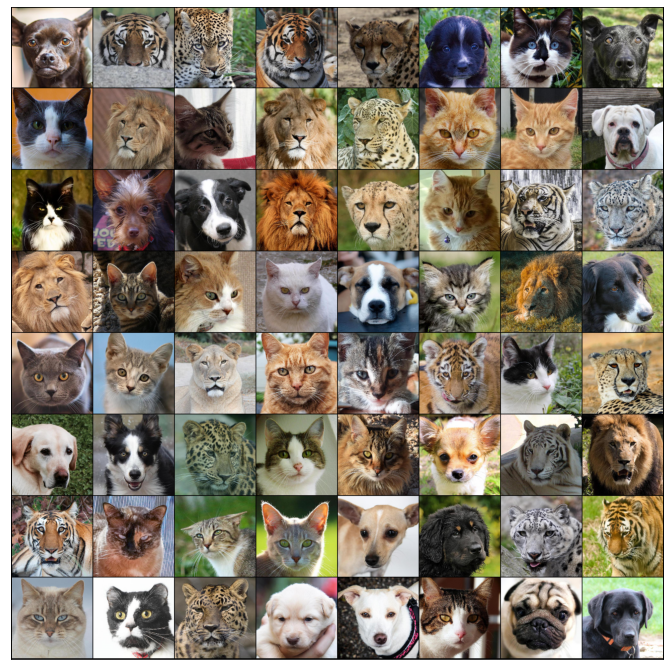

In [5]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    ax.set_xticks([]); ax.set_yticks([])
    break

# Write train/test functions 
(would be nice to rewrite these as methods for a class that inherets from `nn.module`)

In [6]:
# Training function
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
    # Initialize
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    # Loop through each epoch
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 

        # Train on the train dataset
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                # Move to device
                data, target = data.to(device), target.to(device)

                # Zero the gradients out
                optimizer.zero_grad()

                # Get the model output
                output = model(data)

                # Compute Loss
                loss = criterion(output,target)

                # Calculate the gradients
                loss.backward() 

                # Update the weights
                optimizer.step()
                
                # Set the loss
                tepoch.set_postfix(loss=loss.item())
                
                # get accuracy 
                _, predicted = torch.max(output, 1)
                total   += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Append the loss
        train_loss.append(loss.item()) 
        train_acc.append(correct/total)
    
        # Evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total   += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Append validation loss
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
         
    return train_loss, train_acc, validation_loss, validation_acc 

def test(model, device, data_loader,num_classes):
    model.eval()
    correct,total = 0, 0
    confusion_matrix = torch.zeros(num_classes,num_classes)

    for (inputs,labels) in data_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    # Compute accuracy
    acc = 100 * correct / total
    
    return acc, confusion_matrix

# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()


# AlexNet V2
Based on [version 2 of AlexNet](https://arxiv.org/abs/1404.5997).

In [7]:
class AlexNet(nn.Module):
    """
    Implementation from https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
    """
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        # Define convolutional block
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=2,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        # Define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6,6))
        # Define classifier block
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=256 * 6 * 6,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096,out_features=num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convlayers(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)

        return x

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/24 [00:00<?, ?batch/s]

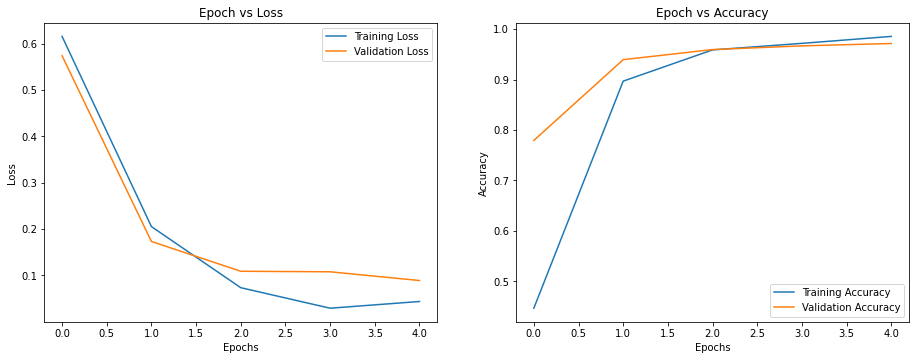

In [8]:
alexnet = AlexNet(num_classes=num_classes).to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(),lr=1e-4,weight_decay=0.0001)
num_epochs = 5
train_loss, train_acc, validation_loss, validation_acc = train(alexnet, dev, train_loader, validate_loader, num_epochs, criterion, optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [9]:
test(alexnet,dev, test_loader,num_classes=num_classes)

(96.65071770334929,
 tensor([[1002.,   15.,   17.,    0.],
         [   4.,  913.,   30.,    0.],
         [   3.,   29.,  913.,    0.],
         [   0.,    0.,    0.,    0.]]))